# Dog Breed Identification

**Overview:**
- Summarizing 'What I've learnt'?
- Prepare Data
- Inspect Data
- Building, Training and Evaluating Models
- Submission
- Notes and Conclusion

### What I've learnt?
- Concepts:
- Code:

**Imports:**

In [1]:
import keras
keras.__version__

/home/jaganz1994/miniconda3/envs/kaggle/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.4'

In [2]:
import os, shutil

In [2]:
import pandas as pd
import numpy as np

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications import VGG16

import matplotlib.pyplot as plt
%matplotlib inline

# custom imports
from scripts import my_utils

%reload_ext autoreload
%autoreload 2

### Preparing Data:

In [3]:
# !ls ../../.kaggle/competitions

In [4]:
# src_dir="../../.kaggle/competitions/dog-breed-identification"
base_dir = '../datasets/dog-breed-identification'
# if not os.path.exists(base_dir): os.makedirs(base_dir)

In [5]:
# my_utils.unpack_dataset(src_dir, base_dir)

In [6]:
!ls ../datasets/dog-breed-identification

bin  bin_1  labels.csv	sample_submission.csv  test  train


In [7]:
mapping = pd.read_csv(os.path.join(base_dir,'labels.csv'))
my_utils.bin_dataset(base_dir, 'train', mapping.values, name = 'bin', validation_split = 0.2)

Tests passed.

This might take a while...
Selected no. of files:  10222
The path already exists.
                    
1.To overwrite. Press '1'
                    
2.To exit Press '2'

2


In [8]:
!ls ../datasets/dog-breed-identification

bin  bin_1  labels.csv	sample_submission.csv  test  train


In [9]:
os.listdir(os.path.join(base_dir, 'bin'))

['val', 'train_map.csv', 'train', 'val_map.csv']

In [10]:
train_dir = os.path.join(base_dir, 'bin', 'train')
val_dir = os.path.join(base_dir, 'bin', 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# directory to save models
save_dir = '../saved_models/dog_breed_identification/1'
if not os.path.isdir(save_dir): os.mkdir(save_dir)

**Data Parameters:**

In [12]:
img_rows, img_cols, img_chnls = 150, 150, 3
input_shape = (img_rows,img_cols,img_chnls)
target_size = input_shape[:-1]

num_classes = np.unique(mapping.values[:,1]).shape[0]

train_sample_count = 8177 
val_sample_count = 2045
test_sample_count = len(os.listdir(test_dir))
batch_size = 256

### Inspecting Data:

### Building, Training and Evaluating Models:

**1. Basic Model:** 

In [13]:
# model
def basic_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    
    return model

In [14]:
model = basic_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [15]:
# compile model
model.compile(optimizer = RMSprop(lr = 1e-3), 
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [16]:
# data generators
train_generator = my_utils.data_generator(train_dir, target_size, batch_size)
val_generator = my_utils.data_generator(val_dir, target_size, batch_size)

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [17]:
# fitting parameters
epochs = 100
callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')]

In [18]:
# training
history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_sample_count // batch_size,
                epochs = epochs,
                callbacks = callbacks,
                validation_data = val_generator,
                validation_steps = val_sample_count // batch_size,
                workers=16,
                use_multiprocessing=True)

Epoch 1/100
31/31 [==============================] - 33s 1s/step - loss: 4.8925 - acc: 0.0100 - val_loss: 4.7731 - val_acc: 0.0112
Epoch 2/100
31/31 [==============================] - 27s 879ms/step - loss: 4.7446 - acc: 0.0176 - val_loss: 5.1887 - val_acc: 0.0095
Epoch 3/100
31/31 [==============================] - 27s 884ms/step - loss: 4.5846 - acc: 0.0323 - val_loss: 4.4815 - val_acc: 0.0442
Epoch 4/100
31/31 [==============================] - 28s 916ms/step - loss: 4.3692 - acc: 0.0535 - val_loss: 4.4121 - val_acc: 0.0453
Epoch 5/100
31/31 [==============================] - 27s 868ms/step - loss: 4.2207 - acc: 0.0760 - val_loss: 4.3918 - val_acc: 0.0587
Epoch 6/100
31/31 [==============================] - 27s 865ms/step - loss: 3.9917 - acc: 0.1121 - val_loss: 4.4379 - val_acc: 0.0598
Epoch 7/100
31/31 [==============================] - 29s 925ms/step - loss: 3.7124 - acc: 0.1554 - val_loss: 4.4810 - val_acc: 0.0783
Epoch 8/100
31/31 [==============================] - 23s 742ms/st

In [19]:
# save model
model_name = 'dbi_basic_1.h5'
model.save(os.path.join(save_dir, model_name))

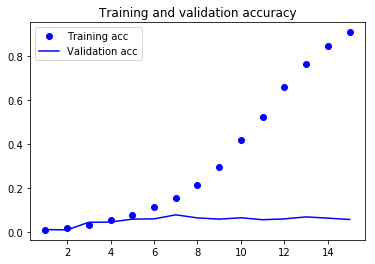

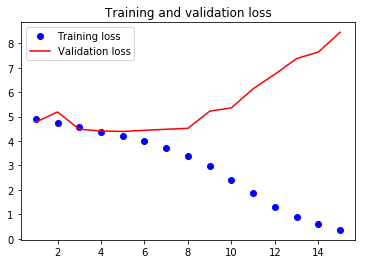

In [20]:
# plot model history
my_utils.plot_history(history)

In [25]:
# # evaluating on test data
# test_generator = my_utils.data_generator(test_dir, target_size, batch_size)
# predictions = model.evaluate_generator(test_generator, 
#                                       steps = test_sample_count // batch_size, 
#                                       max_queue_size=10, 
#                                       workers=1, 
#                                       use_multiprocessing=False, 
#                                       verbose=0)

**2. Basic Model with Data Augmentation:** 

In [26]:
# model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [27]:
# compile model
model.compile(optimizer = RMSprop(lr = 1e-3), 
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [28]:
# data generators
train_generator = my_utils.data_generator(train_dir, target_size, batch_size, augment = True)
val_generator = my_utils.data_generator(val_dir, target_size, batch_size)

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [29]:
# fitting parameters
epochs = 150
callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')]

In [30]:
# training
history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_sample_count // batch_size,
                epochs = epochs,
                callbacks = callbacks,
                validation_data = val_generator,
                validation_steps = val_sample_count // batch_size,
                workers=16,
                use_multiprocessing=True)

Epoch 1/150
31/31 [==============================] - 45s 1s/step - loss: 4.8022 - acc: 0.0093 - val_loss: 4.7722 - val_acc: 0.0106
Epoch 2/150
Epoch 1/150
31/31 [==============================] - 45s 1s/step - loss: 4.7604 - acc: 0.0139 - val_loss: 4.7161 - val_acc: 0.0190
Epoch 3/150
31/31 [==============================] - 45s 1s/step - loss: 4.7117 - acc: 0.0182 - val_loss: 4.6380 - val_acc: 0.0324
Epoch 4/150
31/31 [==============================] - 46s 1s/step - loss: 4.6375 - acc: 0.0271 - val_loss: 4.4949 - val_acc: 0.0408
Epoch 5/150
31/31 [==============================] - 45s 1s/step - loss: 4.5562 - acc: 0.0300 - val_loss: 4.6019 - val_acc: 0.0302
Epoch 6/150
31/31 [==============================] - 45s 1s/step - loss: 4.5083 - acc: 0.0336 - val_loss: 4.6306 - val_acc: 0.0296
Epoch 7/150
31/31 [==============================] - 45s 1s/step - loss: 4.4761 - acc: 0.0387 - val_loss: 4.3181 - val_acc: 0.0620
Epoch 8/150
31/31 [==============================] - 39s 1s/step - loss

In [31]:
# save moodel
model_name = 'dbi_basic_data_aug_2.h5'
model.save(os.path.join(save_dir, model_name))

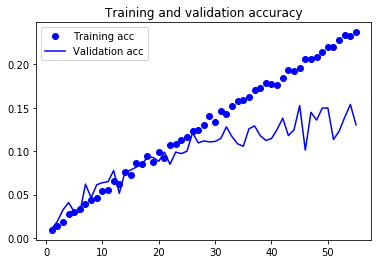

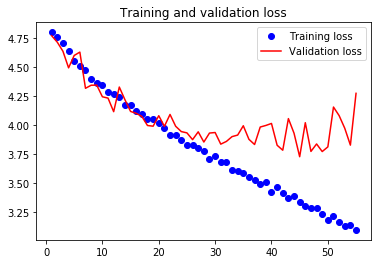

In [32]:
# plot model history
my_utils.plot_history(history)

In [33]:
# # evaluating on test data
# test_generator = my_utils.data_generator(test_dir, target_size, batch_size)
# predictions = model.evaluate_generator(test_generator, 
#                                       steps = test_sample_count // batch_size, 
#                                       max_queue_size=10, 
#                                       workers=1, 
#                                       use_multiprocessing=False, 
#                                       verbose=0)

In [34]:
# predictions = np.argmax(predictions, axis=-1) #multiple categories

# label_map = (train_generator.class_indices)
# label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
# predictions = [label_map[k] for k in predictions]

**3. Using Pre-Trained ConvNet:** 

In [35]:
# vgg16 convbase
vgg16_conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

From here on there's two ways to go about this:
- **Fast Feature Extraction:** Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.
- **Model Extension:** Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

**Fast Feature Extraction:**

In [36]:
# input shape for dense model
feature_shape = (vgg16_conv_base.layers[-1]).output_shape
dm_input_shape = (np.prod(feature_shape[1:]),)

In [37]:
# dense model
model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=dm_input_shape))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               30840     
Total params: 2,128,248
Trainable params: 2,128,248
Non-trainable params: 0
_________________________________________________________________


In [38]:
# compile modle
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [39]:
# data generators
train_generator = my_utils.data_generator(train_dir, target_size, batch_size)
val_generator = my_utils.data_generator(val_dir, target_size, batch_size)

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [40]:
# extract features
train_features, train_labels = my_utils.extract_features(vgg16_conv_base, train_sample_count, 
                                                           train_generator, num_classes, batch_size)
val_features, val_labels = my_utils.extract_features(vgg16_conv_base, val_sample_count, 
                                                       val_generator, num_classes, batch_size)

In [41]:
# reshape extracted features  
train_features = train_features.reshape(train_sample_count, -1)
val_features = val_features.reshape(val_sample_count, -1)

In [42]:
# fitting parameters
epochs = 150
callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')]

In [43]:
# training
history = model.fit(train_features, train_labels,
                    epochs = epochs,
                    callbacks=callbacks,
                    batch_size = batch_size,
                    validation_data = (val_features, val_labels))

Train on 8177 samples, validate on 2045 samples
Epoch 1/150
8177/8177 [==============================] - 1s 98us/step - loss: 4.8509 - acc: 0.0105 - val_loss: 4.7602 - val_acc: 0.0156
Epoch 2/150
8177/8177 [==============================] - 1s 74us/step - loss: 4.7310 - acc: 0.0221 - val_loss: 4.7175 - val_acc: 0.0240
Epoch 3/150
8177/8177 [==============================] - 1s 71us/step - loss: 4.6605 - acc: 0.0319 - val_loss: 4.6521 - val_acc: 0.0357
Epoch 4/150
8177/8177 [==============================] - 1s 73us/step - loss: 4.5663 - acc: 0.0455 - val_loss: 4.5906 - val_acc: 0.0504
Epoch 5/150
8177/8177 [==============================] - 1s 78us/step - loss: 4.4734 - acc: 0.0571 - val_loss: 4.5140 - val_acc: 0.0626
Epoch 6/150
8177/8177 [==============================] - 1s 78us/step - loss: 4.3577 - acc: 0.0757 - val_loss: 4.4339 - val_acc: 0.0812
Epoch 7/150
8177/8177 [==============================] - 1s 80us/step - loss: 4.2607 - acc: 0.0932 - val_loss: 4.3673 - val_acc: 0.0910


In [44]:
# save moodel
model_name = 'dbi_pre_trained_fast_feature_extraction_3.h5'
model.save(os.path.join(save_dir, model_name))

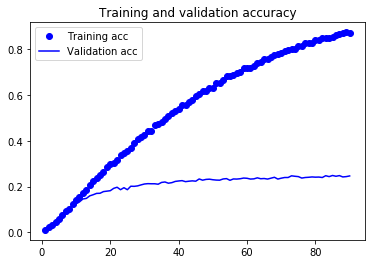

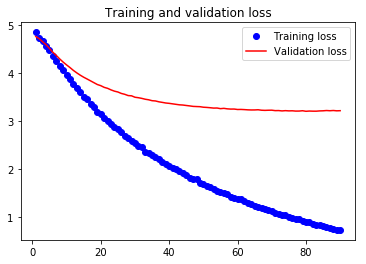

In [45]:
# plot model history
my_utils.plot_history(history)

**Model Extension:**

In [46]:
# model
model = Sequential()

model.add(vgg16_conv_base)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 120)               30840     
Total params: 16,842,936
Trainable params: 16,842,936
Non-trainable params: 0
_________________________________________________________________


In [49]:
# freeze the conv_base
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
vgg16_conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


In [50]:
# compile modle
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [51]:
# data generators
train_generator = my_utils.data_generator(train_dir, target_size, batch_size, augment = True)
val_generator = my_utils.data_generator(val_dir, target_size, batch_size)

Found 8177 images belonging to 120 classes.
Found 2045 images belonging to 120 classes.


In [52]:
# fitting parameters
epochs = 150
callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')]

In [53]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_sample_count // batch_size,
                epochs = epochs,
                callbacks = callbacks,
                validation_data = val_generator,
                validation_steps = val_sample_count // batch_size,
                workers=16,
                use_multiprocessing=True)

Epoch 1/150
31/31 [==============================] - 89s 3s/step - loss: 4.8106 - acc: 0.0148 - val_loss: 4.7132 - val_acc: 0.0251
Epoch 2/150
Epoch 1/150
31/31 [==============================] - 74s 2s/step - loss: 4.7095 - acc: 0.0293 - val_loss: 4.6200 - val_acc: 0.0419
Epoch 3/150
31/31 [==============================] - 66s 2s/step - loss: 4.6301 - acc: 0.0421 - val_loss: 4.5251 - val_acc: 0.0537
Epoch 4/150
31/31 [==============================] - 68s 2s/step - loss: 4.5463 - acc: 0.0568 - val_loss: 4.4333 - val_acc: 0.0620
Epoch 5/150
31/31 [==============================] - 69s 2s/step - loss: 4.4696 - acc: 0.0707 - val_loss: 4.3475 - val_acc: 0.0822
Epoch 6/150
31/31 [==============================] - 67s 2s/step - loss: 4.3798 - acc: 0.0767 - val_loss: 4.2593 - val_acc: 0.0866
Epoch 7/150
31/31 [==============================] - 70s 2s/step - loss: 4.2997 - acc: 0.0900 - val_loss: 4.1929 - val_acc: 0.1118
Epoch 8/150
31/31 [==============================] - 67s 2s/step - loss

In [54]:
# save moodel
model_name = 'dbi_pre_trained_model_extension_4.h5'
model.save(os.path.join(save_dir, model_name))

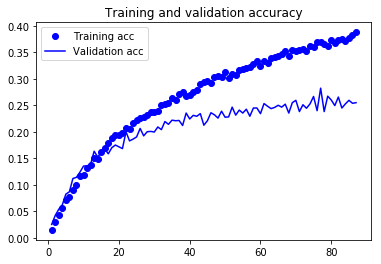

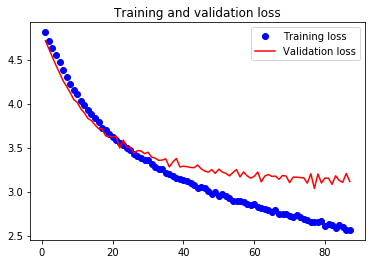

In [55]:
# plot model history
my_utils.plot_history(history)

**Fine-tuning:** 

In [71]:
# freezing everything but the last block
vgg16_conv_base.trainable = True
set_trainable = False
for layer in vgg16_conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [78]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

In [79]:
# fitting parameters
epochs = 100
callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')]

In [80]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_sample_count // batch_size,
                epochs = epochs,
                callbacks = callbacks,
                validation_data = val_generator,
                validation_steps = val_sample_count // batch_size,
                workers=16,
                use_multiprocessing=True)

Epoch 1/100
31/31 [==============================] - 77s 2s/step - loss: 15.9715 - acc: 0.0091 - val_loss: 15.9742 - val_acc: 0.0089
Epoch 2/100
31/31 [==============================] - 70s 2s/step - loss: 15.9658 - acc: 0.0095 - val_loss: 15.9649 - val_acc: 0.0095
Epoch 3/100
31/31 [==============================] - 72s 2s/step - loss: 15.9549 - acc: 0.0101 - val_loss: 15.9469 - val_acc: 0.0106
Epoch 4/100
31/31 [==============================] - 75s 2s/step - loss: 15.9799 - acc: 0.0086 - val_loss: 15.9920 - val_acc: 0.0078
Epoch 5/100
31/31 [==============================] - 73s 2s/step - loss: 15.9674 - acc: 0.0093 - val_loss: 15.9739 - val_acc: 0.0089
Epoch 6/100
31/31 [==============================] - 73s 2s/step - loss: 15.9594 - acc: 0.0098 - val_loss: 15.9739 - val_acc: 0.0089
Epoch 7/100
31/31 [==============================] - 73s 2s/step - loss: 15.9715 - acc: 0.0091 - val_loss: 15.9379 - val_acc: 0.0112
Epoch 8/100
31/31 [==============================] - 72s 2s/step - lo

In [81]:
# save moodel
model_name = 'dbi_fine_tuning_5.h5'
model.save(os.path.join(save_dir, model_name))

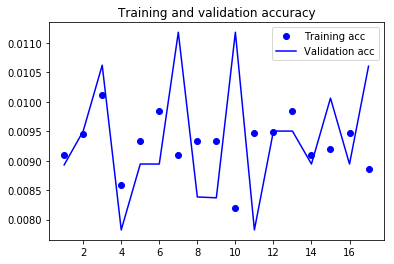

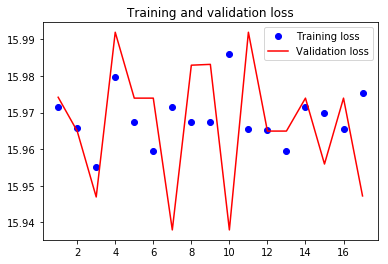

In [82]:
# plot model history
my_utils.plot_history(history)